In [1]:
# Load poem scores
from csv import reader
poem_scores = {}
with open("scores/normalized_scores.csv", "r") as f:
    rows = reader(f)
    header = next(rows)
    for row in rows:
        poem = row[0]
        dataset = row[1]
        poem_score_entry = {}
        poem_score_entry["dataset"] = dataset
        for idx, col in enumerate(header[2:], 2):
            poem_score_entry[col] = float(row[idx])
        poem_scores[poem] = poem_score_entry


In [2]:
from csv import reader
# Load pairs
poem_pairs = []
targets = []
poems = []
pairs = []
with open("data_poems/consolidated_batches.csv") as f:
    csv_reader = reader(f)
    header = next(csv_reader)
    categories = header[5:]
    print(categories)
    for line in csv_reader:
        poem1 = line[1]
        poem2 = line[2]
        if poem1.endswith(" <br>") and line[3] == "gpt2":
            poem1 = poem1[:-5]
        if poem2.endswith(" <br>") and line[4] == "gpt2":
            poem2 = poem2[:-5]
        
        dataset1 = line[3]
        dataset2 = line[4]
        
        pair = {}
        pair["poem1"] = poem1
        pair["poem2"] = poem2
        pair["dataset1"] = dataset1
        pair["dataset2"] = dataset2
        poems.extend([poem1, poem2])
        all_ = []
        for idx, cat in enumerate(categories, 5):
            label = line[idx]
            if label.strip() == "1":
                target = 1
            elif label.strip() == "2":
                target = -1
            elif label.strip():
                target = 0
            else:
                continue
            pair[cat] = target
            poem_pairs.append([poem1, poem2])
            all_.append(target)
        pair['all'] = all_
        pairs.append(pair)


['coherent', 'grammatical', 'melodious', 'moved', 'real', 'rhyming', 'readable', 'comprehensible', 'intense', 'liking']


In [ ]:
from collections import Counter
print(len(poems))
poem_counter = Counter(poems)
poems_at_least_10_times = [poem for poem, count in poem_counter.items() if count >= 10]
print(len(poems_at_least_10_times))

In [ ]:
pairs_with_multi_annotations = [pair for pair in pairs if pair["poem1"] in poems_at_least_10_times or pair["poem2"] in poems_at_least_10_times]
print(len(pairs_with_multi_annotations))

In [3]:
categories = list(pairs[0].keys())[4:]
print(categories)
for method in ["bws", "gppl", "crowdgppl", "bertgppl"]:
    for cat in categories:
        correct = 0.
        wrong = 0.
        for pair in pairs_with_multi_annotations:
            poem1 = pair["poem1"]
            poem2 = pair["poem2"]

            pref = pair[cat]
            score1 = poem_scores[poem1][method + "_" + cat]
            score2 = poem_scores[poem2][method + "_" + cat]
            

            if score1 > score2 and pref == 1:
                correct += 1
            elif score2 > score1 and pref == -1:
                correct +=1
            else:
                wrong += 1
        print(f"{method}_{cat}: {correct/(correct+wrong)}")

    

['coherent', 'grammatical', 'melodious', 'moved', 'real', 'rhyming', 'readable', 'comprehensible', 'intense', 'liking', 'all']


NameError: name 'pairs_with_multi_annotations' is not defined

In [ ]:
with open("data_poems/multi_annotated_poems_10.txt", "w+") as f:
    for poem in poems_at_least_10_times:
        f.write(poem + "\n")
    

In [4]:
corpora = {}
for pair in pairs:
    poem1 = pair["poem1"]
    poem2 = pair["poem2"]
    dataset1 = pair["dataset1"]
    dataset2 = pair["dataset2"]
    current_list1 = corpora.get(dataset1, [])
    current_list2 = corpora.get(dataset2, [])
    current_list1.append(poem1)
    current_list2.append(poem2)
    corpora[dataset1] = current_list1
    corpora[dataset2] = current_list2
print(corpora.keys())


confusion_matrices = {}

# Calculate true positive, true negative, false positive, false negative of annotators for each dataset in category "real"
for ds in corpora:
    poems = corpora[ds]
    tp = 0.
    tn = 0.
    fp = 0.
    fn = 0.
    correct = 0.
    wrong = 0.
    is_real = "gutenberg" == ds
    for poem in poems:
        for pair in pairs:
            annotation = pair["real"]
            poem1 = pair["poem1"]
            poem2 = pair["poem2"]
            if poem not in [poem1, poem2]:
                continue

            # Check how many real poems are in pair
            real_poems_in_pair = 0
            if pair["dataset1"] == "gutenberg":
                real_poems_in_pair += 1
            if pair["dataset2"] == "gutenberg":
                real_poems_in_pair += 1

            # Skip if no real poem is in pair or both are real
            if real_poems_in_pair != 1:
                continue
            
            if poem1 == poem and annotation == 1 and is_real:
                tp += 1
            elif poem1 == poem and annotation == 1 and not is_real:
                fp += 1
            
            elif poem2 == poem and annotation == -1 and is_real:
                tp += 1
            elif poem2 == poem and annotation == -1 and not is_real:
                fp += 1
            
            elif poem1 == poem and annotation == -1 and not is_real:
                tn += 1
            elif poem1 == poem and annotation == -1 and is_real:
                fn += 1
            
            elif poem2 == poem and annotation == 1 and not is_real:
                tn += 1
            elif poem2 == poem and annotation == 1 and is_real:
                fn += 1
    
    
    confusion_matrices[ds] = {"tp": tp, "tn": tn, "fp": fp, "fn": fn}
    ds_acc = (tp+tn)/(tp+tn+fp+fn)
    print(f"Dataset {ds} real acc: {ds_acc}")

print(confusion_matrices)

dict_keys(['lstm', 'gutenberg', 'true_poetry', 'hafez', 'jhamtani', 'ngram', 'gpt2', 'deepspeare'])
False
Dataset lstm real acc: 0.5848585690515807
2940.0
True
Dataset gutenberg real acc: 0.5594225315803042
17560.0
False
Dataset true_poetry real acc: 0.4720752498530276
4359.0
False
Dataset hafez real acc: 0.42515811665495434
3954.0
False
Dataset jhamtani real acc: 0.6182795698924731
3696.0
False
Dataset ngram real acc: 0.5123456790123457
4600.0
False
Dataset gpt2 real acc: 0.6715107478050257
8389.0
False
Dataset deepspeare real acc: 0.5650438946528332
3628.0
{'lstm': {'tp': 0.0, 'tn': 703.0, 'fp': 499.0, 'fn': 0.0}, 'gutenberg': {'tp': 6510.0, 'tn': 0.0, 'fp': 0.0, 'fn': 5127.0}, 'true_poetry': {'tp': 0.0, 'tn': 803.0, 'fp': 898.0, 'fn': 0.0}, 'hafez': {'tp': 0.0, 'tn': 605.0, 'fp': 818.0, 'fn': 0.0}, 'jhamtani': {'tp': 0.0, 'tn': 1035.0, 'fp': 639.0, 'fn': 0.0}, 'ngram': {'tp': 0.0, 'tn': 996.0, 'fp': 948.0, 'fn': 0.0}, 'gpt2': {'tp': 0.0, 'tn': 2218.0, 'fp': 1085.0, 'fn': 0.0}, 'deep

1202.0


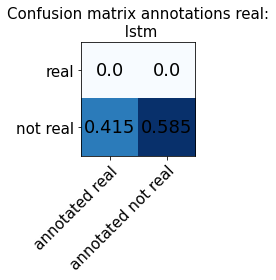

11637.0


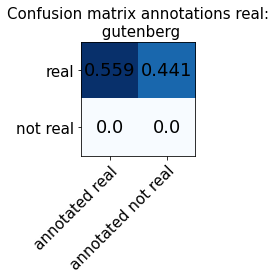

1701.0


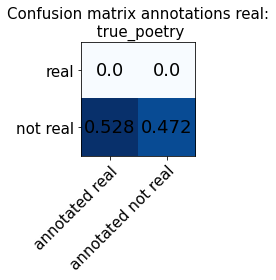

1423.0


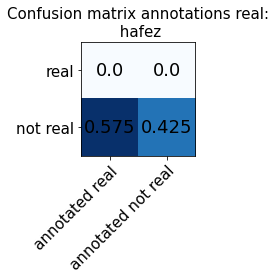

1674.0


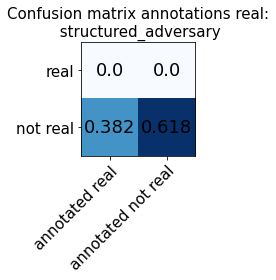

1944.0


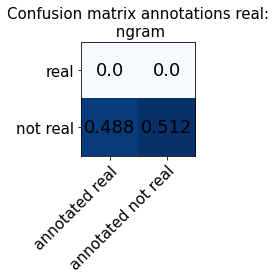

3303.0


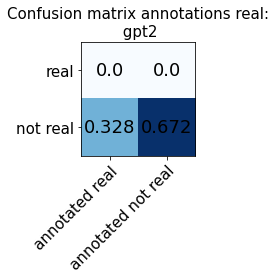

1253.0


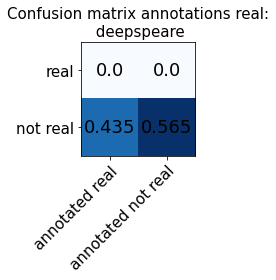

In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

labels = ["real", "not real"]
predictions = ["annotated real", "annotated not real"]


for model in confusion_matrices:
    all_ = sum([val for val in confusion_matrices[model].values()]) 
    print(all_)
    conf_matrix = [[confusion_matrices[model]["tp"]/all_, confusion_matrices[model]["fn"]/all_],
                   [confusion_matrices[model]["fp"]/all_, confusion_matrices[model]["tn"]/all_]]

    # Round to 3 decimal places for better rendering
    conf_matrix_entries = np.round(np.array(conf_matrix), 3)

    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix_entries, plt.get_cmap("Blues"))
    plt.rc('font', size=10)
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(predictions)))
    ax.set_yticks(np.arange(len(labels)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(predictions, fontsize=15)
    ax.set_yticklabels(labels, fontsize=15)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(predictions)):
        for j in range(len(labels)):
            text = ax.text(j, i, conf_matrix_entries[i, j],
                           ha="center", va="center", color="black", fontsize=18)
    ax.set_title(f"Confusion matrix annotations real:\n {model}", fontsize=15)
    fig.tight_layout()
    plt.savefig(f"images/conf_matrix_{model}.png")
    plt.show()

